# 02 Equilibrium Bid & Ask

# Reporte: Modelo Copeland & Galai para el Spread de Equilibrio

Este notebook muestra:
1. Una breve descripción teórica de Copeland & Galai (1983).  
2. Ejemplos de uso de la clase `CopelandGalaiCalc` importada desde el paquete `technical_analysis`.  
3. Gráficas de sensibilidad del spread frente a distintos parámetros.  
4. Conclusión y comparación con el enfoque de Roll (1984).

## 1. Fundamento teórico breve

En un mercado con información asimétrica, el market maker fija un spread $S$ (ask − bid) para protegerse del riesgo de transaccionar contra inversores informados (probabilidad $\pi$).  
Bajo Copeland & Galai (1983):

- El valor fundamental $V$ del activo sigue una distribución conocida.  
- El market maker cotiza  
  $$
  \text{ask} \;=\; \mathbb{E}[V] \;+\; \frac{S}{2}, 
  \qquad 
  \text{bid} \;=\; \mathbb{E}[V] \;-\; \frac{S}{2}.
  $$
- El **beneficio esperado** (pregunta “¿cuánto gana el market maker si opera al ask o al bid?”) se anula en equilibrio:
  $$
  0 \;=\; \frac{1}{2}\Bigl[
    \underbrace{(1-\pi)\bigl(a - \mathbb{E}[V]\bigr) \;+\; \pi\bigl(a - \mathbb{E}[V \mid V > a]\bigr)}_{\text{beneficio en Ask}}
    \;+\;
    \underbrace{(1-\pi)\bigl(\mathbb{E}[V] - b\bigr) \;+\; \pi\bigl(\mathbb{E}[V \mid V < b] - b\bigr)}_{\text{beneficio en Bid}}
  \Bigr].
  $$
- De esa ecuación se obtiene numéricamente $S^*$.  
- **Distribución Normal**:  
  $$
    \mathbb{E}[V] = \mu,\qquad
    \mathbb{E}[V \mid V > a] = \mu \;+\; \sigma \,\frac{\varphi\!\Bigl(\tfrac{a-\mu}{\sigma}\Bigr)}{1 - \Phi\!\Bigl(\tfrac{a - \mu}{\sigma}\Bigr)},
  $$
  $$
    \mathbb{E}[V \mid V < b] = \mu \;-\; \sigma \,\frac{\varphi\!\Bigl(\tfrac{\mu - b}{\sigma}\Bigr)}{\Phi\!\Bigl(\tfrac{\mu - b}{\sigma}\Bigr)}.
  $$
- **Distribución Exponencial** (tasa $\lambda$):  
  $$
    \mathbb{E}[V] = \frac{1}{\lambda},\qquad
    \mathbb{E}[V \mid V > a] = a \;+\; \frac{1}{\lambda},
  $$
  $$
    \mathbb{E}[V \mid V < b] = \frac{\,1 - e^{-\lambda b}(1 + \lambda b)\,}{\lambda\,\bigl(1 - e^{-\lambda b}\bigr)}.
  $$

En este reporte importaremos la clase `CopelandGalaiCalc` (ya implementada en `technical_analysis/utils.py`) y haremos ejemplos para ambas distribuciones.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
from technical_analysis import CopelandGalaiCalc

In [3]:
CG = CopelandGalaiCalc()

bid_n, ask_n, spread_n = CG.bid_ask_normal(mu=102, sigma=7, pi=0.3)
print(f"--- Normal Distribution ---")
print(f"Bid = {bid_n:.4f}, Ask = {ask_n:.4f}, Spread = {spread_n:.4f}\n")

bid_e, ask_e, spread_e = CG.bid_ask_exponential(lam=0.0075, pi=0.01)
print(f"--- Exponential Distribution ---")
print(f"Bid = {bid_e:.4f}, Ask = {ask_e:.4f}, Spread = {spread_e:.4f}")


--- Normal Distribution ---
Bid = 100.3111, Ask = 103.6889, Spread = 3.3778

--- Exponential Distribution ---
Bid = 132.2716, Ask = 134.3951, Spread = 2.1235



### 1. Distribución Normal

- **Valor medio teórico**  
  Para la distribución normal con media μ=102 y desviación estándar σ=7, el valor esperado sin sesgo informacional sería 102.  
- **Bid (100.3111)**  
  El precio de compra (bid) se fija por debajo de la media (≈102) —en este caso, alrededor de 100.31— para compensar al market maker por el riesgo de adquirir el activo de un contrapartida informada.  
- **Ask (103.6889)**  
  El precio de venta (ask) se ubica por encima de la media, en aproximadamente 103.69, con la misma lógica: cubrir el posible desfase en el caso de transaccionar contra un trader mejor informado.  
- **Spread (3.3778)**  
  El spread de equilibrio resulta ser 3.3778 (es decir, 103.6889 − 100.3111).  
  - Dado π=0.3 (30% de probabilidad de que el trader esté informado), el spread asciende a un valor moderado.  
  - A mayor π, esperaríamos un spread más amplio; con π=0.3 y σ=7, la ecuación de beneficio esperado arroja este valor para que el market maker tenga ganancia media igual a cero.


### 2. Distribución Exponencial 

- **Valor medio teórico**  
  Para la distribución exponencial con tasa λ=0.0075, el valor esperado es  
  $\mathbb{E}[V] \;=\; \frac{1}{\lambda} \;=\; \frac{1}{0.0075} \approx 133.3333.$
- **Bid (132.2716)**  
  El precio de compra se sitúa en torno a 132.27, ligeramente por debajo de 133.33, para mitigar el riesgo de comprar a un precio mayor que el valor real en caso de enfrentarse a un trader informado.  
- **Ask (134.3951)**  
  El precio de venta es aproximadamente 134.40, por encima de la media 133.33, de modo que se compense la posibilidad de vender por debajo del valor real.  
- **Spread (2.1235)**  
  El spread resultante (≈2.12) es menor que en el caso normal. Esto se debe a que:
  - La probabilidad de trader informado π=0.01 es muy baja (1%), por lo que el market maker no necesita abrir un spread tan amplio.  
  - La distribución exponencial, con cola asimétrica, produce expectativas condicionales distintas, lo que da como resultado un spread inferior a 3.3778 (obtenido en el caso normal con π=0.3).


## Comparación

1. **Diferencia en magnitud del spread**  
   - La **forma de la distribución** como la **probabilidad de traders informados** afectan la amplitud del spread de equilibrio.

2. **Interpretación práctica**  
   - Cuando la probabilidad de información privilegiada aumenta, el market maker debe ampliar el spread para protegerse.  
   - Por el contrario, con baja probabilidad informacional (π pequeña) o distribución más “liviana” (cola más corta), el spread disminuye.



## 2. Sensibilidad del spread

A continuación graficaremos cómo varía el spread de equilibrio $S^*$ en función de:

1. La probabilidad de que el trader sea informado ($\pi$), manteniendo $\mu=100,\;\sigma=10$ fijos.  
2. La tasa $\lambda$ en la distribución exponencial, manteniendo $\pi=0.1$.  


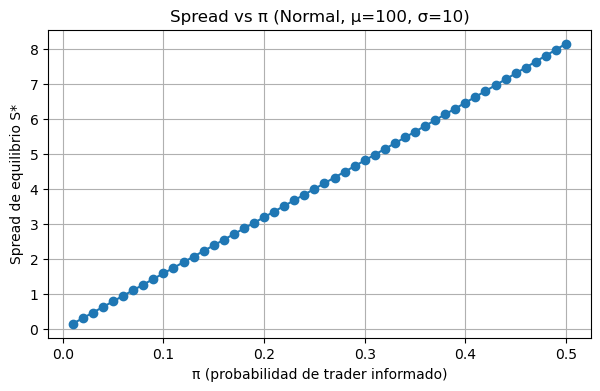

In [6]:
# 2.1 Sensibilidad en Distribución Normal vs π
pis = np.linspace(0.01, 0.5, 50)
spreads_normal = []
for p in pis:
    _, _, s = CG.bid_ask_normal(mu=100, sigma=10, pi=p)
    spreads_normal.append(s)

plt.figure(figsize=(7,4))
plt.plot(pis, spreads_normal, marker='o', linestyle='-')
plt.xlabel("π (probabilidad de trader informado)")
plt.ylabel("Spread de equilibrio S*")
plt.title("Spread vs π (Normal, μ=100, σ=10)")
plt.grid(True)
plt.show()


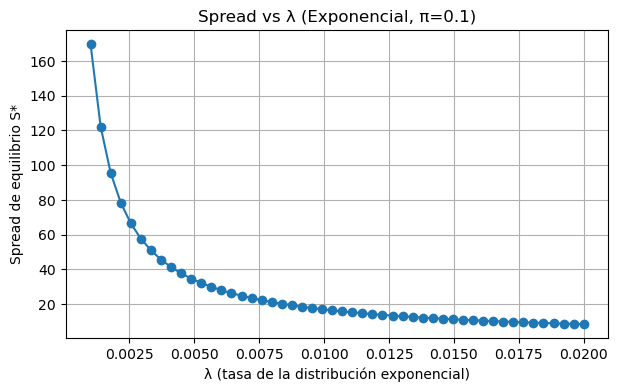

In [7]:
# 2.2 Sensibilidad en Distribución Exponencial vs λ
lams = np.linspace(0.001, 0.02, 50)
spreads_exp = []
for lam in lams:
    _, _, s = CG.bid_ask_exponential(lam=lam, pi=0.1)
    spreads_exp.append(s)

plt.figure(figsize=(7,4))
plt.plot(lams, spreads_exp, marker='o', linestyle='-')
plt.xlabel("λ (tasa de la distribución exponencial)")
plt.ylabel("Spread de equilibrio S*")
plt.title("Spread vs λ (Exponencial, π=0.1)")
plt.grid(True)
plt.show()


## 3. Interpretación de los resultados

- En la **gráfica 2.1**, se observa que a medida que aumenta $\pi$ (más probabilidad de traders informados), el spread $S^*$ crece casi de manera convexa.  
  Esto tiene sentido: cuanto mayor es la probabilidad de que alguien esté mejor informado, más alto debe ser el spread para compensar al market maker.  

- En la **gráfica 2.2**, a medida que sube $\lambda$ (el valor medio de la exponencial baja, pues $\mathbb{E}[V]=1/\lambda$), el spread refleja cómo varía el riesgo de asimetría informacional en una distribución con cola más pesada.  

A partir de estas curvas podemos calibrar parámetros si comparamos spreads teóricos con los spreads reales observados en datos de alta frecuencia.


## 4. Conclusión y comparación con Roll (1984)

1. **Spread en Copeland & Galai**  
   - Surge por el riesgo informacional.  
   - Se calcula resolviendo:
     $$
       0 \;=\; \tfrac{1}{2}\Bigl[
         (1-\pi)\bigl(a - \mathbb{E}[V]\bigr)
         \;+\; \pi\bigl(a - \mathbb{E}[V \mid V > a]\bigr)
         \;+\;
         (1-\pi)\bigl(\mathbb{E}[V] - b\bigr)
         \;+\; \pi\bigl(\mathbb{E}[V \mid V < b] - b\bigr)
       \Bigr].
     $$
   - Hay dependencia explícita de $\pi$ y de la forma de la distribución de $V$ (Normal o Exponencial).

2. **Enfoque de Roll (1984)**  
   - Propuesto por Richard Roll:
     $$
       S_{\text{Roll}} \;=\; 2\,\sqrt{-\operatorname{cov}(r_t,\,r_{t-1})}\,,
     $$
     donde $r_t$ son retornos logarítmicos de precios.  
   - No asume una distribución paramétrica de $V$. En cambio utiliza la correlación negativa entre retornos consecutivos como proxy de costos de transacción e información.  
   - **Ventaja**: se puede estimar directamente con series de precios de alta frecuencia.  
   - **Desventaja**: no distingue la fuente exacta del spread (información vs. inventarios, por ejemplo).

3. **Comparativa práctica**  
   - **Copeland–Galai**: ideal para experimentos de simulación o para calibrar un modelo teórico de market making cuando conocemos (o suponemos) $\pi$ y la forma de la distribución de $V$.  
   - **Roll**: fácil de implementar en datos reales (requiere solo precios), sirve para obtener un “spread implícito” promedio, pero no explica su origen interno.  

4. **Aplicaciones prácticas de Copeland & Galai**  
   1. **Market making cuantitativo**: determinar rangos iniciales de quotes (bid/ask) según percepción de riesgo informacional.  
   2. **Análisis de liquidez**: comparar el spread empírico observado en el libro de órdenes con el spread teórico para detectar episodios de alta asimetría informacional.  
   3. **Estimación de probabilidad $\pi$**: a partir de datos de microestructura, ajustar $\pi$ para que el spread teórico se aproxime al spread real.  
